In [39]:
import pandas as pd
import numpy as np
import fastquant
import datetime
import requests

from pytrends.request import TrendReq 

In [2]:
date_start = "2020-06-01"
date_end = "2022-06-01"

In [3]:
start = datetime.datetime.strptime(date_start, '%Y-%m-%d')
end = datetime.datetime.strptime(date_end, '%Y-%m-%d')

total_days = end - start
total_days = total_days.days
# total_days

In [ ]:
BTC_1 = fastquant.get_crypto_data("BTC/USDT", date_start, date_end)
ETH_1 = fastquant.get_crypto_data("ETH/USDT", date_start, date_end)
ADA_1 = fastquant.get_crypto_data("ADA/USDT", date_start, date_end)

# Multi Index
BTC_1.columns = pd.MultiIndex.from_product([['BTC_1'], BTC_1.columns])
ETH_1.columns = pd.MultiIndex.from_product([['ETH_1'], ETH_1.columns])
ADA_1.columns = pd.MultiIndex.from_product([['ADA_1'], ADA_1.columns])

# Combine Crypto Info
price_data = pd.concat([BTC_1, ETH_1, ADA_1], axis=1)
price_data = price_data.dropna()
# price_data.head()

In [ ]:
price_data

BTC_1                                                 ETH_1  \
                open      high       low     close         volume     open   
dt                                                                           
2020-06-02  10202.71  10228.99   9266.00   9518.04  108970.773151   248.23   
2020-06-03   9518.02   9690.00   9365.21   9666.24   46252.644939   237.71   
2020-06-04   9666.32   9881.63   9450.00   9789.06   57456.100969   244.54   
2020-06-05   9788.14   9854.75   9581.00   9621.16   47788.050050   243.22   
2020-06-06   9621.17   9735.00   9531.05   9666.30   32752.950893   240.04   
...              ...       ...       ...       ...            ...      ...   
2022-05-28  28629.81  29266.00  28450.00  29031.33   34479.351270  1727.26   
2022-05-29  29031.33  29587.78  28839.21  29468.10   27567.347640  1792.21   
2022-05-30  29468.10  32222.00  29299.62  31734.22   96785.947600  1813.64   
2022-05-31  31734.23  32399.00  31200.01  31801.04   62433.116320  1998.78   
2022-06-01  31801.05  31982.97  29301.00  29805.83  103395.633820  1941.90   

                                                       ADA_1           \
               high      low    close        volume     open     high   
dt                                                                      
2020-06-02   253.80   225.00   237.71  9.555209e+05  0.08096  0.08248   
2020-06-03   245.00   232.71   244.52  5.029281e+05  0.07872  0.08610   
2020-06-04   246.60   236.00   243.21  6.693693e+05  0.08558  0.09039   
2020-06-05   247.87   239.14   240.03  5.025474e+05  0.08882  0.08914   
2020-06-06   244.70   237.83   241.94  3.894231e+05  0.08519  0.08730   
...             ...      ...      ...           ...      ...      ...   
2022-05-28  1808.98  1722.26  1792.22  5.582712e+05  0.45660  0.46930   
2022-05-29  1827.40  1759.96  1813.64  4.324306e+05  0.46460  0.48270   
2022-05-30  2013.00  1803.18  1998.78  8.149228e+05  0.48190  0.57770   
2022-05-31  2016.45  1925.00  1941.90  7.511034e+05  0.56980  0.68930   
2022-06-01  1972.58  1763.75  1817.95  1.037841e+06  0.62660  0.63140   

                                           
                low    close       volume  
dt                                         
2020-06-02  0.07080  0.07872  807890970.3  
2020-06-03  0.07707  0.08558  746675602.9  
2020-06-04  0.08342  0.08882  876595811.4  
2020-06-05  0.08393  0.08517  480984869.2  
2020-06-06  0.08475  0.08614  274342754.6  
...             ...      ...          ...  
2022-05-28  0.44810  0.46460  105935970.4  
2022-05-29  0.45590  0.48200   88626528.9  
2022-05-30  0.47720  0.56980  259278313.4  
2022-05-31  0.56780  0.62680  663619489.7  
2022-06-01  0.53590  0.55160  355477399.6  

[730 rows x 15 columns]

In [ ]:
url = f"https://api.alternative.me/fng/?limit={total_days}"
response = requests.get(url)
response.raise_for_status()
data = response.json()

In [ ]:
rows = []
for i in range(total_days):
	fear_value = data['data'][i]['value']
	fear_classification = data['data'][i]['value_classification']
	t = int(data['data'][i]['timestamp'])
	t = datetime.datetime.fromtimestamp(t).strftime('%Y-%m-%d')
	rows.append([t, fear_value, fear_classification])

df = pd.DataFrame(rows,columns=['Date', 'Fear Value', "Fear Classification"])
df.set_index("Date", inplace=True)
df.sort_index(ascending=True, inplace=True)
df_fear = df.copy()
# df_fear

,Fear Value,Fear Classification
Date,,
2020-06-02,48,Neutral
2020-06-03,54,Neutral
2020-06-04,53,Neutral
2020-06-05,54,Neutral
2020-06-06,54,Neutral
...,...,...
2022-05-28,14,Extreme Fear
2022-05-29,10,Extreme Fear
2022-05-30,16,Extreme Fear


In [ ]:
df = pd.concat([df_fear, price_data], axis=1, join='inner')
df

,Fear Value,Fear Classification,"(BTC_1, open)","(BTC_1, high)","(BTC_1, low)","(BTC_1, close)","(BTC_1, volume)","(ETH_1, open)","(ETH_1, high)","(ETH_1, low)","(ETH_1, close)","(ETH_1, volume)","(ADA_1, open)","(ADA_1, high)","(ADA_1, low)","(ADA_1, close)","(ADA_1, volume)"
2020-06-02,48,Neutral,10202.71,10228.99,9266.00,9518.04,108970.773151,248.23,253.80,225.00,237.71,9.555209e+05,0.08096,0.08248,0.07080,0.07872,807890970.3
2020-06-03,54,Neutral,9518.02,9690.00,9365.21,9666.24,46252.644939,237.71,245.00,232.71,244.52,5.029281e+05,0.07872,0.08610,0.07707,0.08558,746675602.9
2020-06-04,53,Neutral,9666.32,9881.63,9450.00,9789.06,57456.100969,244.54,246.60,236.00,243.21,6.693693e+05,0.08558,0.09039,0.08342,0.08882,876595811.4
2020-06-05,54,Neutral,9788.14,9854.75,9581.00,9621.16,47788.050050,243.22,247.87,239.14,240.03,5.025474e+05,0.08882,0.08914,0.08393,0.08517,480984869.2
2020-06-06,54,Neutral,9621.17,9735.00,9531.05,9666.30,32752.950893,240.04,244.70,237.83,241.94,3.894231e+05,0.08519,0.08730,0.08475,0.08614,274342754.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-28,14,Extreme Fear,28629.81,29266.00,28450.00,29031.33,34479.351270,1727.26,1808.98,1722.26,1792.22,5.582712e+05,0.45660,0.46930,0.44810,0.46460,105935970.4
2022-05-29,10,Extreme Fear,29031.33,29587.78,28839.21,29468.10,27567.347640,1792.21,1827.40,1759.96,1813.64,4.324306e+05,0.46460,0.48270,0.45590,0.48200,88626528.9
2022-05-30,16,Extreme Fear,29468.10,32222.00,29299.62,31734.22,96785.947600,1813.64,2013.00,1803.18,1998.78,8.149228e+05,0.48190,0.57770,0.47720,0.56980,259278313.4
2022-05-31,17,Extreme Fear,31734.23,32399.00,31200.01,31801.04,62433.116320,1998.78,2016.45,1925.00,1941.90,7.511034e+05,0.56980,0.68930,0.56780,0.62680,663619489.7


In [76]:
pytrend = TrendReq()
kw_list=['Bitcoin', 'Ethereum', 'Cardano']
df_hist = pytrend.get_historical_interest(kw_list, year_start=2020, month_start=6, day_start=1, year_end=2022, month_end=6, day_end=1, cat=0, geo='', gprop='', sleep=1, frequency='daily')

In [74]:
df_hist

,Bitcoin,Ethereum,Cardano,isPartial
date,,,,
2020-06-01,11,1,0,False
2020-06-02,16,2,0,False
2020-06-03,13,1,0,False
2020-06-04,12,1,0,False
2020-06-05,12,1,0,False
...,...,...,...,...
2022-05-27,36,7,2,False
2022-05-28,31,6,1,False
2022-05-29,29,6,1,False


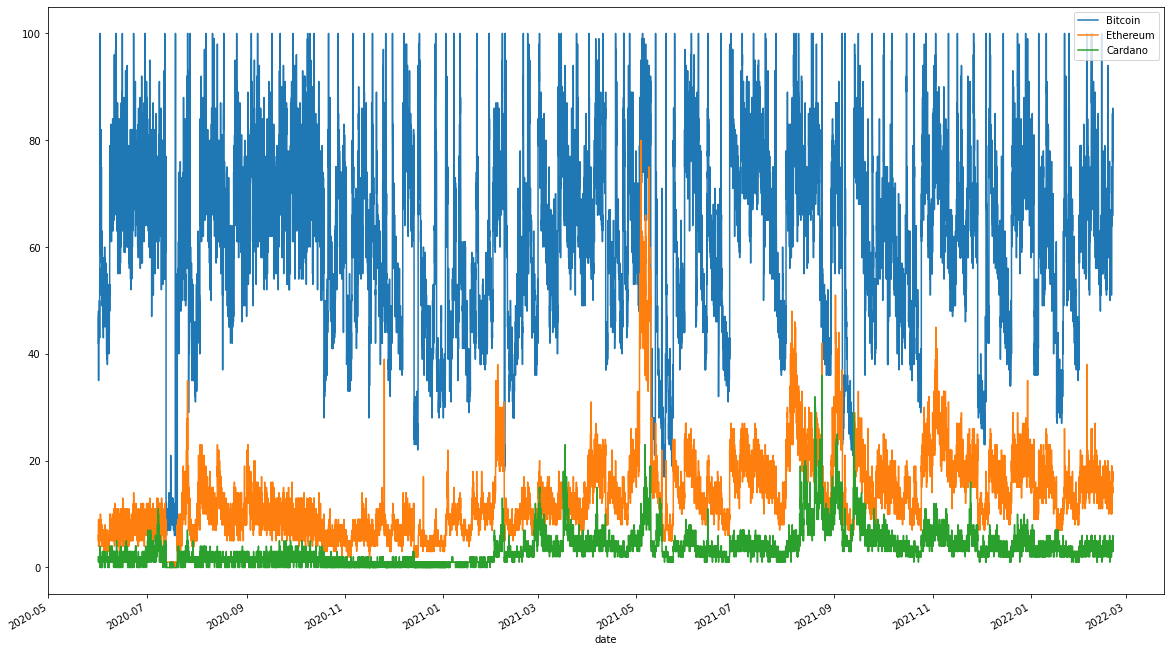

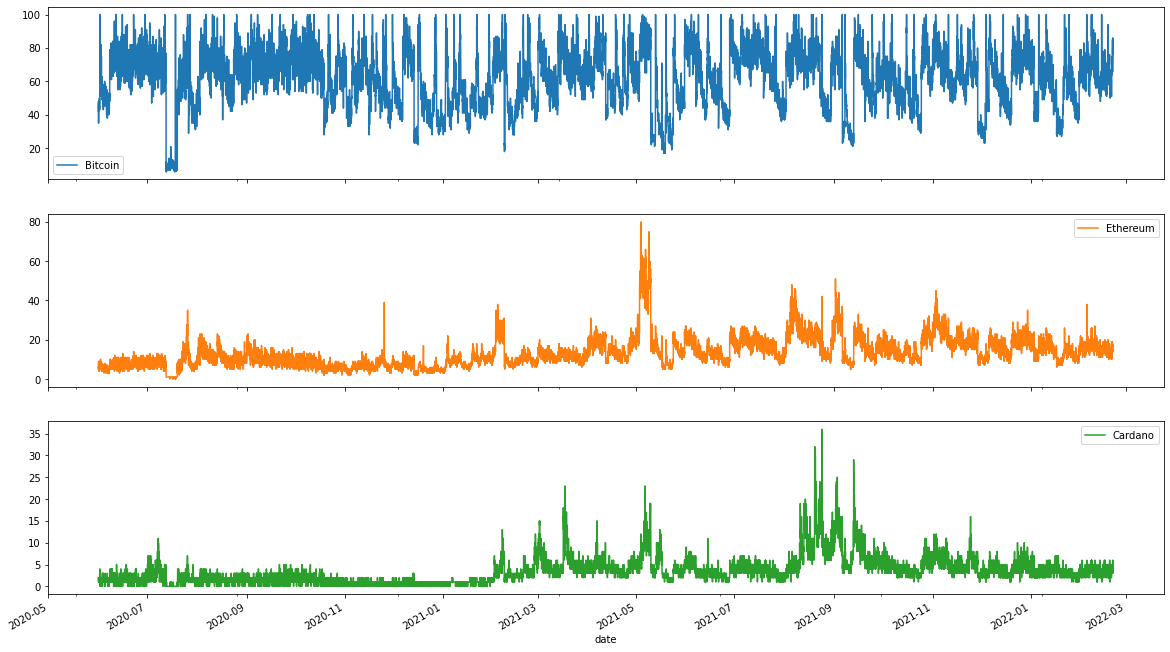

In [ ]:
#visualise
#plot a timeseries chart
df_hist.plot(figsize=(20, 12))
#plot seperate graphs, using theprovided keywords
df_hist.plot(subplots=True, figsize=(20, 12));

In [56]:
df_hist.index#.hour

DatetimeIndex(['2020-06-01 00:00:00', '2020-06-01 01:00:00',
               '2020-06-01 02:00:00', '2020-06-01 03:00:00',
               '2020-06-01 04:00:00', '2020-06-01 05:00:00',
               '2020-06-01 06:00:00', '2020-06-01 07:00:00',
               '2020-06-01 08:00:00', '2020-06-01 09:00:00',
               ...
               '2022-02-20 15:00:00', '2022-02-20 16:00:00',
               '2022-02-20 17:00:00', '2022-02-20 18:00:00',
               '2022-02-20 19:00:00', '2022-02-20 20:00:00',
               '2022-02-20 21:00:00', '2022-02-20 22:00:00',
               '2022-02-20 23:00:00', '2022-02-21 00:00:00'],
              dtype='datetime64[ns]', name='date', length=15210, freq=None)

In [ ]:
15210

633.75

In [63]:
df_hist.resample('1D').sum()

,Bitcoin,Ethereum,Cardano,isPartial
date,,,,
2020-06-01,1155,137,37,0
2020-06-02,1608,166,32,0
2020-06-03,1290,136,34,0
2020-06-04,1220,133,40,0
2020-06-05,1199,130,31,0
...,...,...,...,...
2022-02-17,1559,351,76,0
2022-02-18,1633,340,75,0
2022-02-19,1446,331,71,0


In [ ]:
day1 = df_hist.head(24)
day1[['Bitcoin']].sum()

Bitcoin    1155
dtype: int64

In [ ]:
lastday = df_hist.tail(24)
lastday[['Bitcoin']].sum()

Bitcoin    1637
dtype: int64

In [ ]:
lastday = df_hist.tail(24)
lastday[['Ethereum']].sum()

Ethereum    358
dtype: int64

In [10]:
# price_data.head(1)
# price_data.tail(1)
# df_fear

In [11]:
# rows[0]

In [12]:
# df = pd.DataFrame(
# 	{
# 	'value':fear_value,
# 	'value_classification':fear_classification,
# 	}, index=[t],
# )
# df.index = df.index.rename("Date")
# df.index = pd.to_datetime(df.index)
# df.index

In [13]:
# total_days = total_days.days

In [14]:
# df_fear = pd.DataFrame.from_dict(data)
# df_fear

In [15]:
# display(data)

In [16]:
# fear_value = data['data'][0]['value']
# fear_value
# fear_classification = data['data'][0]['value_classification']
# fear_classification
# t = int(data['data'][0]['timestamp'])
# t = datetime.datetime.fromtimestamp(t).strftime('%Y-%m-%d')

In [17]:
# print(fear_value)
# print(fear_classification)
# print(t)

In [18]:
# df_fear = pd.DataFrame(
# 	{
# 	'value':fear_value,
# 	'value_classification':fear_classification,
# 	}, index=[t],
# )
# df_fear.index = df_fear.index.rename("Date")
# df_fear.index = pd.to_datetime(df_fear.index)
# df_fear.index

In [19]:
# df_fear.index

In [20]:
# t = int(data['data'][0]['timestamp'])
# # datetime.datetime.fromtimestamp(t).strftime('%Y-%m-%d %H:%M:%S')
# datetime.datetime.fromtimestamp(t).strftime('%Y-%m-%d')

In [39]:
# data['data'][1]#['value']

In [40]:
# import datetime
# datetime.datetime.fromtimestamp(t).strftime('%Y-%m-%d %H:%M:%S')
# # '2012-09-13 14:22:50' # Local time

In [41]:
# t = int(data['data'][1]['timestamp'])
# datetime.datetime.fromtimestamp(t).strftime('%Y-%m-%d %H:%M:%S')